# EDA weather data

Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import lightgbm as lgb

In [4]:
from scipy import stats
import os
import sys
import pathlib
# myfunction_path = str(pathlib.Path("../../common").resolve())
# myfunction_path = os.path.join(os.path.dirname(__file__), "../../common") #uncomment for py scripts
myfunction_path = str(pathlib.Path("./common").resolve())
sys.path.insert(0, myfunction_path)
from myfunctions import *

pd.set_option("display.precision", 2)

In [5]:
path = 'data/weather/'

In [6]:
file_source = 'jena_climate_2009_2016.csv'

# output files
file_x_train = "x_train.csv"
file_x_val = "x_val.csv"
file_x_test = "x_test.csv"
file_y_train = "y_train.csv"
file_y_val = "y_val.csv"
file_y_test = "y_test.csv"

In [7]:
df_source = pd.read_csv(f'{path}{file_source}', index_col=0)
df_source.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
df_source.shape

(420551, 15)

In [9]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
# truncated df
df = df_source[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

### Data cleaning

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.21,8.36,913.60,984.20,989.57,994.72,1015.29
T (degC),70091.0,9.45,8.42,-22.76,3.35,9.41,15.48,37.28
Tpot (K),70091.0,283.49,8.50,250.85,277.44,283.46,289.53,311.21
Tdew (degC),70091.0,4.96,6.73,-24.80,0.24,5.21,10.08,23.06
rh (%),70091.0,76.01,16.47,13.88,65.21,79.30,89.40,100.00
VPmax (mbar),70091.0,13.58,7.74,0.97,7.77,11.82,17.61,63.77
VPact (mbar),70091.0,9.53,4.18,0.81,6.22,8.86,12.36,28.25
VPdef (mbar),70091.0,4.04,4.90,0.00,0.87,2.19,5.30,46.01
sh (g/kg),70091.0,6.02,2.66,0.51,3.92,5.59,7.80,18.07
H2OC (mmol/mol),70091.0,9.64,4.23,0.81,6.29,8.96,12.49,28.74


In [11]:
# Imputation

field = 'wv (m/s)'
value_old = -9999.0
value_new = 0
df[field] = np.where(df[field] == value_old, value_new, df[field])

field = 'max. wv (m/s)'
value_old = -9999.0
value_new = 0
df[field] = np.where(df[field] == value_old, value_new, df[field])

C:\Users\Sing\AppData\Local\Temp/ipykernel_27036/35503740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = np.where(df[field] == value_old, value_new, df[field])
C:\Users\Sing\AppData\Local\Temp/ipykernel_27036/35503740.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = np.where(df[field] == value_old, value_new, df[field])


In [12]:
df['wv (m/s)'].min(), df['max. wv (m/s)'].min()

(0.0, 0.0)

In [13]:
# converting to pd timestamp format
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [14]:
day_in_sec = 24*60*60
year_in_sec = (365.2425)*day_in_sec

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day_in_sec))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day_in_sec))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year_in_sec))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year_in_sec))

C:\Users\Sing\AppData\Local\Temp/ipykernel_27036/3247794760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day_in_sec))
C:\Users\Sing\AppData\Local\Temp/ipykernel_27036/3247794760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day_in_sec))
C:\Users\Sing\AppData\Local\Temp/ipykernel_27036/3247794760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [15]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,0.26,0.97,0.01,1.0
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,0.50,0.87,0.01,1.0
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,0.71,0.71,0.01,1.0
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,0.87,0.50,0.01,1.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,0.97,0.26,0.01,1.0


### Look for correlated features with label

In [16]:
label = "T (degC)"
df.corr()[label].sort_values()

rho (g/m**3)      -0.96
Year cos          -0.76
rh (%)            -0.57
Year sin          -0.23
Day sin           -0.21
Day cos           -0.16
p (mbar)          -0.05
wd (deg)           0.04
wv (m/s)           0.09
max. wv (m/s)      0.12
VPdef (mbar)       0.76
sh (g/kg)          0.87
H2OC (mmol/mol)    0.87
VPact (mbar)       0.87
Tdew (degC)        0.90
VPmax (mbar)       0.95
Tpot (K)           1.00
T (degC)           1.00
Name: T (degC), dtype: float64

In [17]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [18]:
# Reordering the columns - label to be the last column
columns_new = df.columns.to_list()
columns_new.remove(label)
columns_new.append(label)
df = df[columns_new].copy()

In [19]:
### Correlation matrix heatmap

In [20]:
df_corr = df.corr()

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

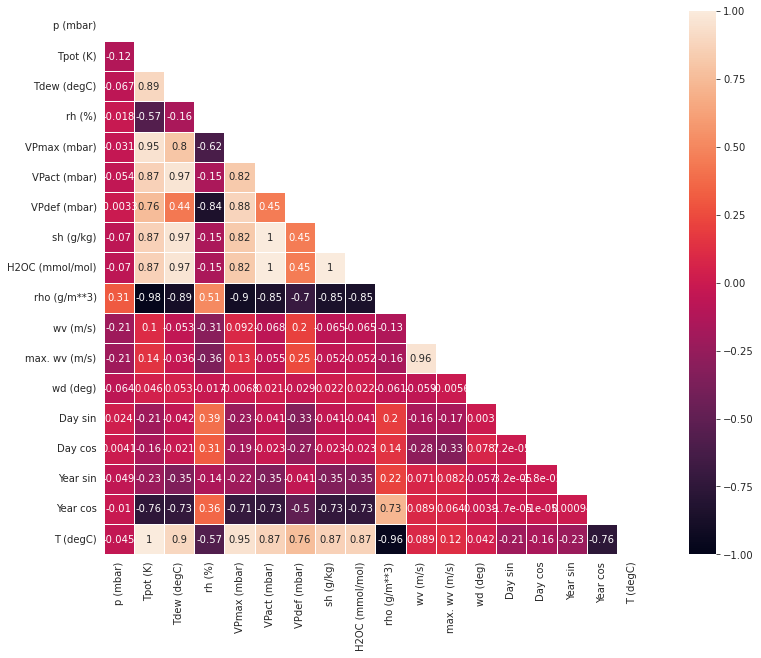

In [21]:
# heatmap with white upper triangle
plt.figure(figsize = (15,10))
with sns.axes_style("white"):
    sns.heatmap(df_corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5)
plt.savefig(f"{path}heatmap.jpg")
plt.show();

### Features of low correlations

Several features, especially temperate features, are too highly correlated with the label, potentially data leakage
- Tdew (degC)        0.90
- Tpot (K)           1.00

For illustration purpose, assume we take into account features of relatively low correlations, to be fed into various models

In [22]:
# features of low correlations
low_corr_features = ["Year sin", "Day sin", "Day cos", "p (mbar)", "wd (deg)", "wv (m/s)", "max. wv (m/s)"]

### Data preparation for modelling

In [23]:
# Split the data

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Separating out labels

In [25]:
y = df[label].copy()

In [26]:
y.head()

5    -8.05
11   -8.88
17   -8.81
23   -9.05
29   -9.63
Name: T (degC), dtype: float64

### Features

In [27]:
x_all = df.drop(columns=[label]).copy()

In [28]:
x_all = df[low_corr_features].copy()

In [29]:
x_all.head()

,Year sin,Day sin,Day cos,p (mbar),wd (deg),wv (m/s),max. wv (m/s)
5,0.01,0.26,0.97,996.50,192.7,0.21,0.63
11,0.01,0.50,0.87,996.62,190.3,0.25,0.63
17,0.01,0.71,0.71,996.84,167.2,0.18,0.63
23,0.01,0.87,0.50,996.99,240.0,0.10,0.38
29,0.01,0.97,0.26,997.46,157.0,0.40,0.88


### Train test split + normalization

In [30]:
total_days = x_all.shape[0]

# in percentages instead of decimals, to avoid round-off errors
train_ratio = 70
val_ratio = 20

# LSTM input length
n_input = 6
total_window_size = 7 # no stride in label
n_features = x_all.shape[1]

In [31]:
x_all.head()

,Year sin,Day sin,Day cos,p (mbar),wd (deg),wv (m/s),max. wv (m/s)
5,0.01,0.26,0.97,996.50,192.7,0.21,0.63
11,0.01,0.50,0.87,996.62,190.3,0.25,0.63
17,0.01,0.71,0.71,996.84,167.2,0.18,0.63
23,0.01,0.87,0.50,996.99,240.0,0.10,0.38
29,0.01,0.97,0.26,997.46,157.0,0.40,0.88


In [32]:
x_all.shape

(70091, 7)

In [33]:
int(train_ratio/100*total_days), int((train_ratio + val_ratio)/100*total_days)

(49063, 63081)

In [34]:
int((train_ratio + val_ratio)/100*total_days)

63081

In [35]:
x_train = x_all.iloc[:int(train_ratio/100*total_days),:]
x_val = x_all.iloc[int(train_ratio/100*total_days):int((train_ratio + val_ratio)/100*total_days),:]
x_test = x_all.iloc[int((train_ratio + val_ratio)/100*total_days):,:]

In [36]:
x_train.shape, x_val.shape, x_test.shape

((49063, 7), (14018, 7), (7010, 7))

In [37]:
x_train_mean = x_train.mean()

In [38]:
x_train_sd = x_train.std()

In [39]:
x_train = (x_train - x_train_mean)/x_train_sd
x_val = (x_val - x_train_mean)/x_train_sd
x_test = (x_test - x_train_mean)/x_train_sd

In [40]:
x_train.shape, x_val.shape, x_test.shape

((49063, 7), (14018, 7), (7010, 7))

In [41]:
x_train.describe()

,Year sin,Day sin,Day cos,p (mbar),wd (deg),wv (m/s),max. wv (m/s)
count,4.91e+04,4.91e+04,4.91e+04,4.91e+04,4.91e+04,4.91e+04,4.91e+04
mean,2.06e-16,-1.53e-17,-2.61e-17,9.87e-13,-2.51e-14,8.83e-15,7.27e-15
std,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,-1.50e+00,-1.41e+00,-1.41e+00,-9.05e+00,-1.98e+00,-1.40e+00,-1.54e+00
25%,-9.86e-01,-1.00e+00,-1.00e+00,-6.09e-01,-6.33e-01,-7.39e-01,-7.60e-01
50%,7.75e-02,7.68e-05,1.02e-04,5.47e-02,2.67e-01,-2.31e-01,-2.25e-01
75%,9.87e-01,1.00e+00,1.00e+00,6.55e-01,6.93e-01,4.79e-01,5.21e-01
max,1.35e+00,1.41e+00,1.41e+00,2.91e+00,2.13e+00,7.72e+00,8.59e+00


### Splitting y

In [42]:
y_train = y.iloc[:int(train_ratio/100*total_days)]
y_val = y.iloc[int(train_ratio/100*total_days):int((train_ratio + val_ratio)/100*total_days)]
y_test = y.iloc[int((train_ratio + val_ratio)/100*total_days):]

In [43]:
y_train.shape, y_val.shape, y_test.shape

((49063,), (14018,), (7010,))

In [44]:
type(y_train)

pandas.core.series.Series

In [45]:
y_train

5         -8.05
11        -8.88
17        -8.81
23        -9.05
29        -9.63
          ...  
294353    16.94
294359    16.72
294365    15.52
294371    15.26
294377    14.76
Name: T (degC), Length: 49063, dtype: float64

### Saving output files

In [46]:
x_train.head()

,Year sin,Day sin,Day cos,p (mbar),wd (deg),wv (m/s),max. wv (m/s)
5,-0.06,0.37,1.37,0.95,0.22,-1.27,-1.26
11,-0.06,0.71,1.22,0.96,0.19,-1.24,-1.26
17,-0.06,1.00,1.00,0.99,-0.07,-1.29,-1.26
23,-0.06,1.22,0.71,1.00,0.76,-1.34,-1.37
29,-0.06,1.37,0.37,1.06,-0.19,-1.14,-1.16


In [47]:
x_train.shape, x_val.shape, x_test.shape

((49063, 7), (14018, 7), (7010, 7))

In [48]:
x_train.to_csv(f'{path}{file_x_train}')
x_val.to_csv(f'{path}{file_x_val}')
x_test.to_csv(f'{path}{file_x_test}')

In [49]:
y_train.shape, y_val.shape, y_test.shape

((49063,), (14018,), (7010,))

In [50]:
pd.DataFrame(y_train).to_csv(f'{path}{file_y_train}')
pd.DataFrame(y_val).to_csv(f'{path}{file_y_val}')
pd.DataFrame(y_test).to_csv(f'{path}{file_y_test}')

In [51]:
# to read the data from files
# x_train = pd.read_csv(f'{path}{file_x_train}', index_col=0)
# x_val = pd.read_csv(f'{path}{file_x_val}', index_col=0)
# x_test = pd.read_csv(f'{path}{file_x_test}', index_col=0)

# y_train = pd.read_csv(f'{path}{file_y_train}', index_col=0).iloc[:,0]
# y_val = pd.read_csv(f'{path}{file_y_val}', index_col=0).iloc[:,0]
# y_test = pd.read_csv(f'{path}{file_y_test}', index_col=0).iloc[:,0]

### Investigating y distributions

<AxesSubplot:xlabel='T (degC)', ylabel='Count'>

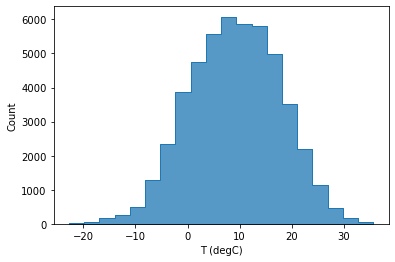

In [52]:
sns.histplot(y_train,element="step", bins=20)

<AxesSubplot:xlabel='T (degC)', ylabel='Count'>

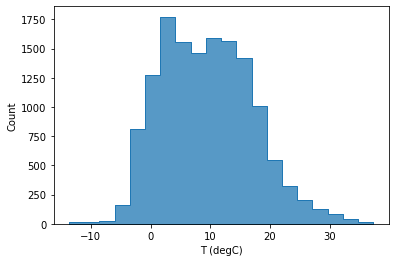

In [53]:
sns.histplot(y_val,element="step", bins=20)

<AxesSubplot:xlabel='T (degC)', ylabel='Count'>

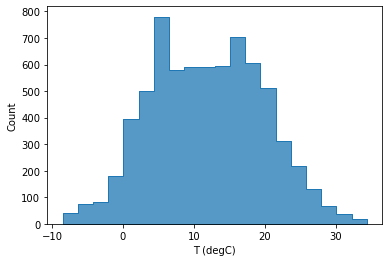

In [54]:
sns.histplot(y_test,element="step", bins=20)